<center>

---

Introducción a la Inteligencia Artificial

Felipe Muñoz Echeverri

---

</center>

In [1]:
!pip install tensorflow -q
!pip install visualkeras -q
!pip install albumentations -q
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import kagglehub
from PIL import Image
import visualkeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 18.0 MB/s eta 0:00:00


In [2]:
tf.random.set_seed(42)
np.random.seed(42)

# Definir el tamaño de las imágenes
img_size = 224

# Cargar de datos

In [3]:
path = kagglehub.dataset_download("mohnishsaiprasad/forest-fire-images")

train_dir = os.path.join(path, 'Data/Train_Data')

X = []
y = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    class_label = 1 if class_name == 'Fire' else 0
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            # Abrir la imagen y convertirla a RGB
            img = Image.open(img_path).convert('RGB')
            # Redimensionar la imagen
            img = img.resize((img_size, img_size))
            X.append(np.array(img))
            y.append(class_label)
        except:
            continue

# Convertir a arrays NumPy y normalizar
X = np.array(X).astype('float32') / 255.0
y = np.array(y)

100%|██████████| 385M/385M [00:06<00:00, 66.6MB/s]

Extracting files...


# Dividir en conjuntos de entrenamiento y testing

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Distribución de clases

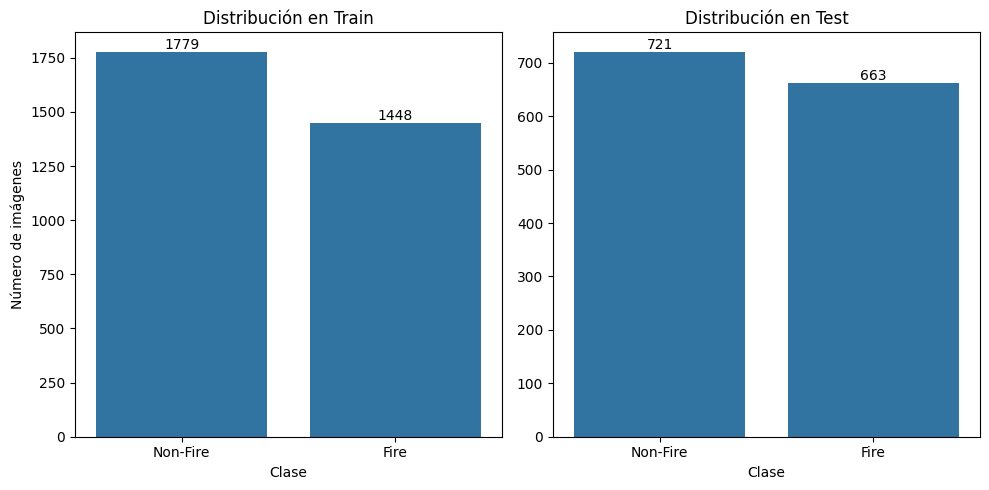

In [5]:
plt.figure(figsize=(10, 5))

# Train
plt.subplot(1, 2, 1)
train_dist = pd.Series(Y_train).value_counts()
sns.barplot(x=train_dist.index, y=train_dist.values)
plt.title('Distribución en Train')
plt.xlabel('Clase')
plt.xticks(train_dist.index, ['Non-Fire', 'Fire'])
plt.ylabel('Número de imágenes')
for i, v in enumerate(train_dist.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Test
plt.subplot(1, 2, 2)
val_dist = pd.Series(Y_test).value_counts()
sns.barplot(x=val_dist.index, y=val_dist.values)
plt.title('Distribución en Test')
plt.xlabel('Clase')
plt.xticks(val_dist.index, ['Non-Fire', 'Fire'])
for i, v in enumerate(val_dist.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Arquitectura del modelo


## Resumen de Funciones del Modelo

| Función | Propósito | Parámetros |
|---|---|---|
| `Sequential()` | Crea un modelo secuencial, donde las capas se apilan una tras otra. |  |
| `Conv2D()` | Crea una capa convolucional 2D, que extrae características de la imagen utilizando filtros. | `filters`: Número de filtros. `kernel_size`: Tamaño del kernel (filtro). `activation`: Función de activación. `input_shape`: Forma de la imagen de entrada (solo en la primera capa). |
| `MaxPooling2D()` | Crea una capa de Max Pooling 2D, que reduce la dimensionalidad espacial de la imagen. | `pool_size`: Tamaño de la ventana de pooling. |
| `Dropout()` | Crea una capa de Dropout, que desactiva aleatoriamente neuronas durante el entrenamiento para prevenir el sobreajuste. | `rate`: Tasa de dropout (fracción de neuronas a desactivar). |
| `SpatialDropout2D()` | Similar a Dropout, pero opera sobre canales de características en lugar de neuronas individuales. | `rate`: Tasa de dropout. |
| `Flatten()` | Crea una capa de aplanamiento, que convierte la salida multidimensional de las capas convolucionales en un vector unidimensional. |  |
| `Dense()` | Crea una capa densa (completamente conectada), que realiza una transformación lineal de la entrada. | `units`: Número de neuronas en la capa. `activation`: Función de activación. |

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


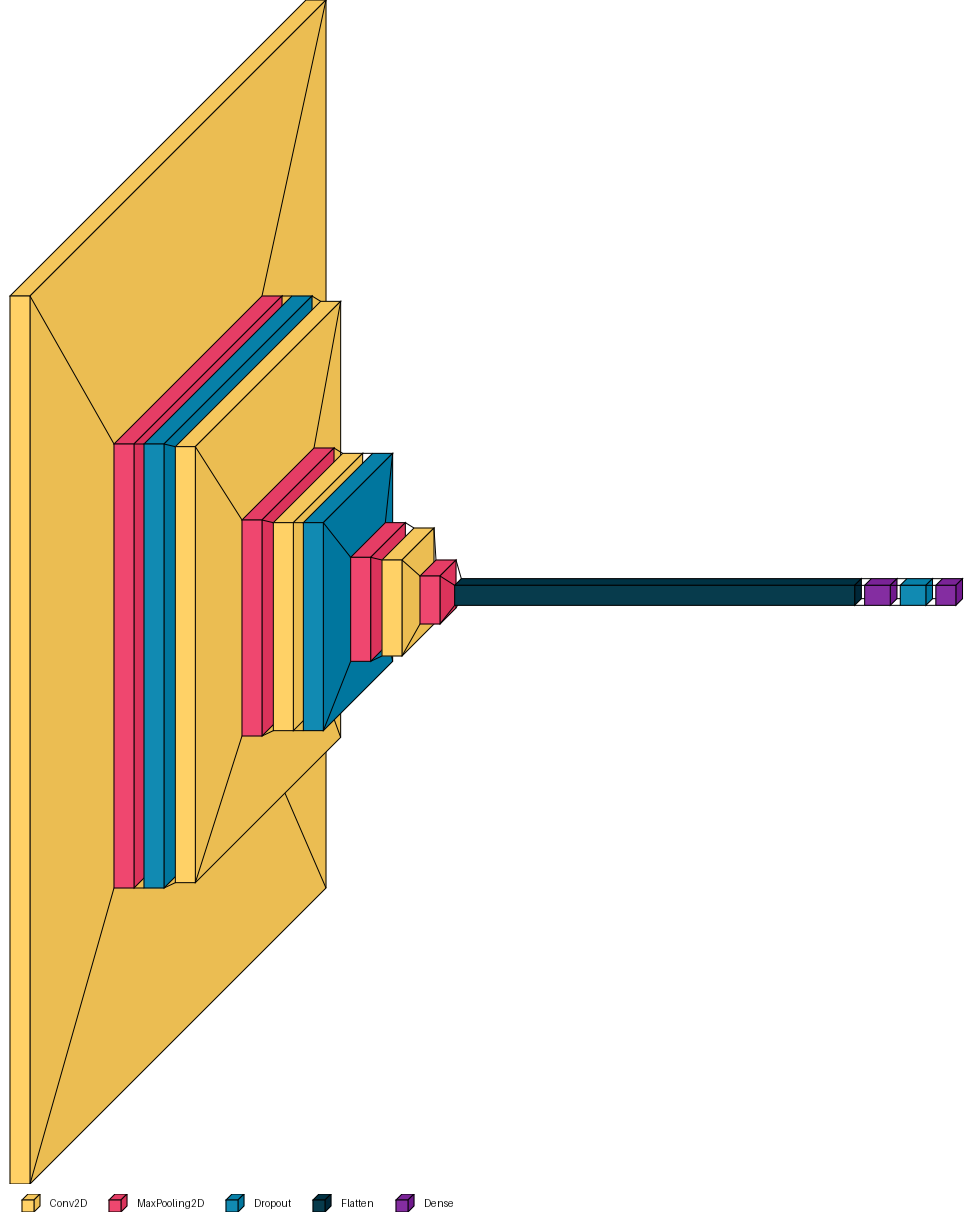

In [6]:
model = tf.keras.Sequential([
    # Bloques convolucionales
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Capas densas
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

visualkeras.layered_view(model, legend=True)

# Compilar el modelo

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 52, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,821,601 (18.39 MB)

 Trainable params: 4,821,601 (18.39 MB)

 Non-trainable params: 0 (0.00 B)

# Aumento de datos

Crea un objeto `ImageDataGenerator` que se usa para aumentar artificialmente el tamaño del conjunto de datos de imágenes aplicando transformaciones aleatorias.

* **`rotation_range`:** Rota las imágenes aleatoriamente dentro del rango especificado (en grados).
* **`width_shift_range`:** Desplaza las imágenes horizontalmente (como fracción del ancho total).
* **`height_shift_range`:** Desplaza las imágenes verticalmente (como fracción de la altura total).
* **`shear_range`:** Aplica una transformación de corte aleatoria.
* **`zoom_range`:** Acerca o aleja las imágenes aleatoriamente.
* **`horizontal_flip`:** Voltea las imágenes horizontalmente aleatoriamente.
* **`fill_mode`:** Define cómo se rellenan los píxeles que quedan fuera de los límites después de las transformaciones ('nearest' rellena con el valor del píxel más cercano).


In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


### EarlyStopping

El callback `EarlyStopping` detiene el entrenamiento cuando una métrica monitoreada deja de mejorar.

**Parámetros:**

* **`monitor`:** La métrica a monitorear (por ejemplo, 'val_loss').
* **`mode`:**  'min' si se desea minimizar la métrica, 'max' si se desea maximizarla.
* **`patience`:** Número de épocas sin mejora antes de detener el entrenamiento.
* **`restore_best_weights`:** Si es True, restaura los pesos del modelo al mejor valor de la métrica monitoreada.


### ReduceLROnPlateau

El callback `ReduceLROnPlateau` reduce la tasa de aprendizaje cuando una métrica monitoreada deja de mejorar.

**Parámetros:**

* **`monitor`:** La métrica a monitorear (por ejemplo, 'val_loss').
* **`factor`:** Factor por el cual se reduce la tasa de aprendizaje.
* **`patience`:** Número de épocas sin mejora antes de reducir la tasa de aprendizaje.

In [9]:
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5)


## Entrenamiento
Toma los datos de entrenamiento, las etiquetas y varios otros parámetros para configurar el proceso de entrenamiento.


### Parámetros:

* **`batch_size`:** Define el tamaño del lote.
* **`epochs`:** Número de épocas de entrenamiento. Una época es una pasada completa a través de todo el conjunto de datos de entrenamiento.
* **`validation_data`:** Datos de validación. Se utilizan para evaluar el rendimiento del modelo durante el entrenamiento.
   * **Conceptos:** Datos de validación.
* **`callbacks`:** Lista de callbacks. Los callbacks son funciones que se ejecutan durante el entrenamiento para realizar acciones específicas

In [10]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=48),
          epochs=10,
          validation_data=(X_test, Y_test),
          callbacks=[early_stopping,reduce_lr_on_plateau])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 57s 620ms/step - accuracy: 0.7466 - loss: 0.5693 - val_accuracy: 0.8851 - val_loss: 0.3243 - learning_rate: 0.0010
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 502ms/step - accuracy: 0.9063 - loss: 0.2531 - val_accuracy: 0.9227 - val_loss: 0.2088 - learning_rate: 0.0010
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 534ms/step - accuracy: 0.9107 - loss: 0.2269 - val_accuracy: 0.9191 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 509ms/step - accuracy: 0.9220 - loss: 0.2001 - val_accuracy: 0.9227 - val_loss: 0.2079 - learning_rate: 0.0010
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 512ms/step - accuracy: 0.9378 - loss: 0.1764 - val_accuracy: 0.9408 - val_loss: 0.1790 - learning_rate: 0.0010
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 508ms/step - accuracy: 0.9471 - loss: 0.1533 - val_accuracy: 0.9444 - val_loss: 0.1501 - learning_rate: 0.0010
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 515ms/step - accuracy: 0.9450 - loss: 0.

# Graficar el historial de entrenamiento

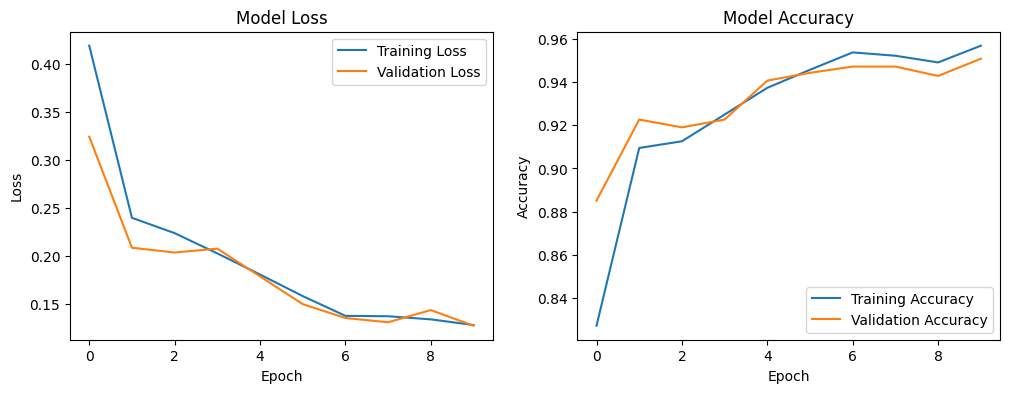

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Matriz de confusión

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


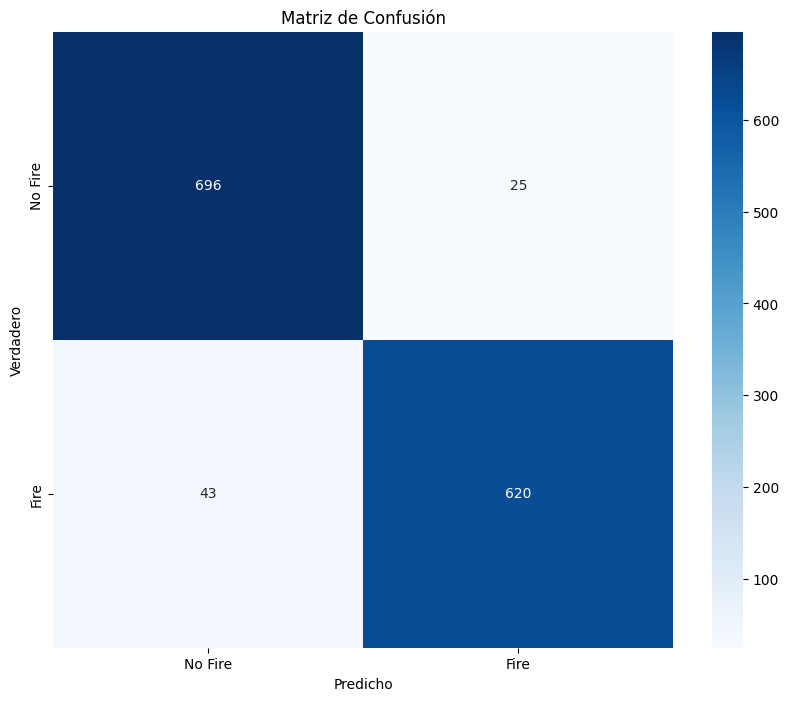

In [12]:
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fire', 'Fire'],
            yticklabels=['No Fire', 'Fire'])
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()


# Métricas de rendimiento

In [13]:
print("\nReporte de Clasificación Detallado:")
print(classification_report(Y_test, y_pred_classes, target_names=['No Fire', 'Fire']))


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

     No Fire       0.94      0.97      0.95       721
        Fire       0.96      0.94      0.95       663

    accuracy                           0.95      1384
   macro avg       0.95      0.95      0.95      1384
weighted avg       0.95      0.95      0.95      1384



#Ejemplos

In [39]:
def show_predictions(model, test_data, test_labels, num_images=9):
    predictions = model.predict(test_data)
    plt.figure(figsize=(10, 30))

    for i in range(num_images):
        plt.subplot(11, 5, i + 1)
        plt.imshow(test_data[i])

        pred_prob = predictions[i][0]
        pred_label = 'Fire' if pred_prob > 0.5 else 'Non-Fire'
        true_label = 'Fire' if test_labels[i] == 1 else 'Non-Fire'

        color = 'green' if pred_label == true_label else 'red'

        plt.title(f'Predicción: {pred_label}\n' +
                 f'(Prob: {pred_prob:.2%})\n' +
                 f'Real: {true_label}',
                 color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizando predicciones con probabilidades:")
show_predictions(model, X_test, Y_test, num_images=55)

Output hidden; open in https://colab.research.google.com to view.